In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [2]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [3]:
def plot_image_and_mask(image, masks):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    # Plot the image
    plt.imshow(image_with_masks)
    plt.show()
    

In [4]:
from dataloaders.solar_dk_dataset import SolarDKDataset
import torchvision.transforms.v2 as transforms

train_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
validation_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/val"

train_dataset = SolarDKDataset(train_folder)
validation_dataset = SolarDKDataset(validation_folder)

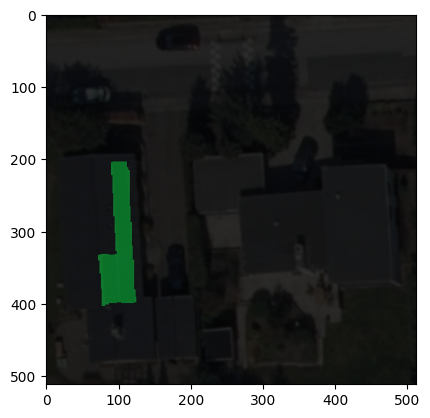

In [27]:
inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1.]),
])

image, mask = train_dataset[1]
plot_image_and_mask(inv_transform(image), mask)

### Load the dataset

In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataset = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=4)

### Train the model

In [7]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [8]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

torch.Size([4, 3, 512, 512]) torch.Size([4, 2, 512, 512])


In [9]:
from torchmetrics.functional.classification import dice

class CombinedBCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super(CombinedBCEDiceLoss, self).__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()

    def forward(self, y_hat, y):
        bce = self.bce(y_hat, y)
        y_hat = torch.sigmoid(y_hat)
        dice_loss = 1 - dice(y_hat, y.int())
        return bce + dice_loss

/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


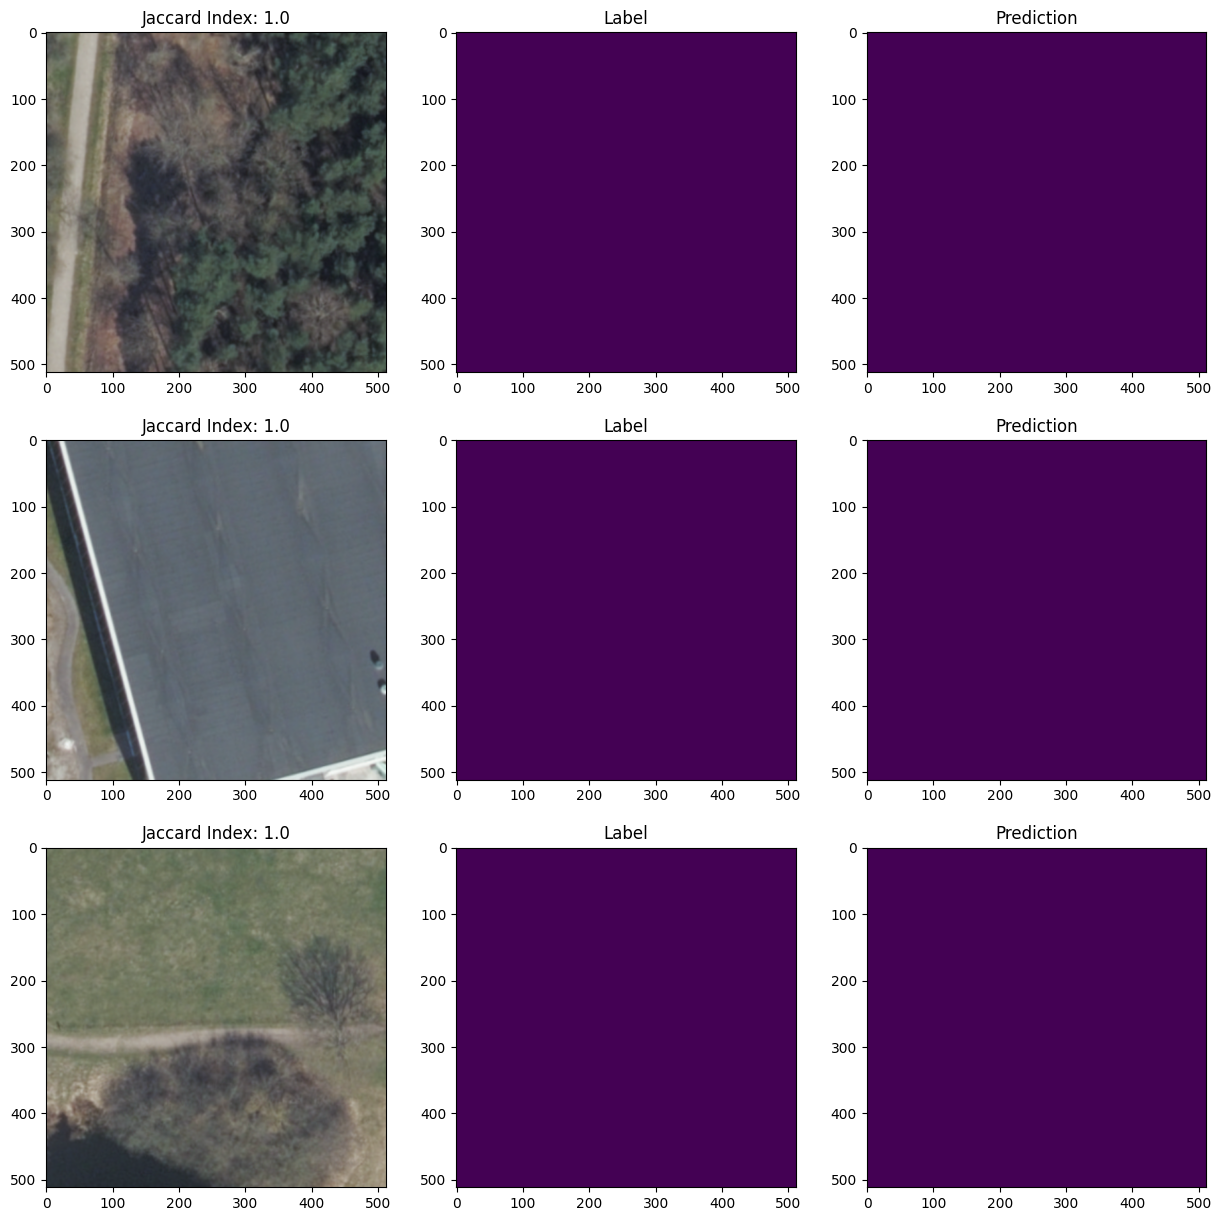

In [51]:
import torch
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from PIL import Image

from torchmetrics.functional import jaccard_index, accuracy, precision, recall, f1_score, dice

test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"

model = BaseModel.load_from_checkpoint("lightning_logs/version_206463/checkpoints/last.ckpt")

test_dataset = SolarDKDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

task = "multiclass"
num_classes = 2

# Loop on train dataloader until mask is not just zeros
# for image, label in test_loader:
#     # Check if the second channel of any of the batches is not all zeros
#     if (label[:, 1] != 0).any():
#         id = (label[:, 1] != 0).nonzero(as_tuple=True)[0][0]
#         print(id)
#         break
        
# Estimate the model on the test set
model.eval()

top_3 = []

with torch.no_grad():
    for image, label in test_loader:
        output = model(image)
        
        image = image.squeeze()
        image = inv_transform(image)
        
        output = output.squeeze()
        label = label.squeeze()
        
        output_predictions = output.argmax(dim=0).float().squeeze()
        label = label.argmax(dim=0).float().squeeze()
        
        jaccard = jaccard_index(output_predictions, label, task=task, num_classes=num_classes)
        dice_coef = dice(output_predictions, label.int())
        
        dice_jaccard_ratio = dice_coef / jaccard
    
        if len(top_3) < 3:
            top_3_jaccard.append((jaccard, image, label, output_predictions))
            top_3_jaccard.sort(reverse=True, key=lambda x: x[0])
        elif jaccard > top_3_jaccard[-1][0]:
            top_3_jaccard[-1] = (jaccard, image, label, output_predictions)
            top_3_jaccard.sort(reverse=True, key=lambda x: x[0])
    
# print(f"Dice Score: {dice(output_predictions, label.int())}")
# print(f"Jaccard Index: {jaccard_index(output_predictions, label, task=task, num_classes=num_classes)}")
# print(f"Accuracy: {accuracy(output_predictions, label, task=task, num_classes=num_classes)}")
# print(f"Precision: {precision(output_predictions, label, task=task, num_classes=  num_classes)}")
# print(f"Recall: {recall(output_predictions, label, task=task, num_classes=num_classes)}")
# print(f"F1 Score: {f1_score(output_predictions, label, task=task, num_classes=num_classes)}")

# Make a 3x3 plot with the top 3 jaccard indexes
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, (jaccard, image, label, output_predictions) in enumerate(top_3_jaccard):
    axs[i, 0].imshow(image.permute(1, 2, 0))
    axs[i, 0].set_title(f"Jaccard Index: {jaccard}")
    
    axs[i, 1].imshow(label)
    axs[i, 1].set_title("Label")
    
    axs[i, 2].imshow(output_predictions)
    axs[i, 2].set_title("Prediction")

plt.show()
    
        